The purpose of this task is to evaluate and compare the performances of three models, namely Ridge Classifier, Random Forest and MLP. Cross validation is done in order to ensure generalization and robust model selection. \
The dataset consists of image features extracted from three different surface types: grass, sand, and stairs. The image urls to unsplash are read from three txt files and the images are preprocessed. \
At first, first order and second order features are extracted from the images. Feature relations are shown in plots. Then the models are evaluated using 5-fold stratified cross validation. \
After that, we take another step and perform nested cross validation on the models. 4-fold inner cross-validation is used for hyperparameter tuning (GridSearchCV). 5-fold outer cross-validation is used to assess generalization performance on unseen data. The models were compared based on mean accuracy across outer folds, helping determine the best-performing classifier while ensuring stable evaluation across different data splits.

## Data preparation

Importing packages

In [36]:
import os
import numpy as np
import pandas as pd
import requests
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Utility functions for loading urls and processing image

In [37]:
def get_image_urls(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file.readlines()]
    
def load_and_preprocess_images(urls, label, size=(128, 128)):
    images, labels = [], []
    for url in urls:
        resp = requests.get(url, stream=True)
        if resp.status_code == 200:
            img_arr = np.asarray(bytearray(resp.raw.read()), dtype=np.uint8)
            img = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
            height, width = img.shape[:2]
            min_dim = min(height, width)
            center = (width // 2, height // 2)
            cropped_img = img[center[1] - min_dim // 2:center[1] + min_dim // 2,
                               center[0] - min_dim // 2:center[0] + min_dim // 2]
            img_resized = cv2.resize(cropped_img, size)
            images.append(img_resized)
            labels.append(label)
    return images, labels

Reading the urls from image files

In [38]:
grass_urls = get_image_urls('grass.txt')
sand_urls = get_image_urls('sand.txt')
stairs_urls = get_image_urls('stairs.txt')

Downloading and processing the images

In [39]:
grass_images, grass_labels = load_and_preprocess_images(grass_urls, 'grass')
sand_images, sand_labels = load_and_preprocess_images(sand_urls, 'sand')
stairs_images, stairs_labels = load_and_preprocess_images(stairs_urls, 'stairs')

Combine the data

In [40]:
images = np.array(grass_images + sand_images + stairs_images)
labels = np.array(grass_labels + sand_labels + stairs_labels)

Converting the image to greyscale and quantizing them

In [41]:
def quantize_and_grayscale(img, levels=8):
    grey_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return (grey_scale // (256 // levels)).astype(np.uint8)

grayscale_images = [quantize_and_grayscale(img) for img in images]

## Feature extraction

### First order texture measures

- Calculate the below mentioned color features for each image
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [42]:
# Feature Extraction: First-order texture features
def extract_color_features(img):
    means = np.mean(img, axis=(0,1))  # RGB means
    vars_ = np.var(img, axis=(0,1))   # RGB variances
    return np.concatenate((means, vars_))

color_features = np.array([extract_color_features(img) for img in images])

### Second order texture measures

- Gray-Level-Co-Occurrence (GLCM) features (4 features) 
    - For each image
        - calculate the GLC matrix
        - calculate the "correlation" feature using the GLC matrix that you acquired 
            - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)

Distance = 1: Captures fine textures and small-scale patterns by analyzing short-range pixel interactions. \
Distance = 2: Identifies broader patterns by considering slightly longer-range dependencies between pixel 

In [43]:
# Feature Extraction: GLCM
def extract_glcm_features(gray_img, distances=[1, 2], angles=[0, np.pi/2]):
    # Explanation of distance choice
    # Distance = 1: Captures fine textures and small-scale patterns by analyzing short-range pixel interactions.
    # Distance = 2: Identifies broader patterns by considering slightly longer-range dependencies between pixel intensities.
    glcm = graycomatrix(gray_img, distances=distances, angles=angles, levels=8, symmetric=True, normed=True)
    correlation = [graycoprops(glcm, 'correlation').flatten()]
    return np.concatenate(correlation)

glcm_features = np.array([extract_glcm_features(img) for img in grayscale_images])

Gather features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

In [44]:
X = np.hstack((color_features, glcm_features))
y = labels
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Feature relationships

Make illustrations of the feature relationships, and discuss the results

### Pairplot



In [45]:
# Converting to dataframe to visulize the data
df = pd.DataFrame(X_scaled, columns=[f'Feature_{i}' for i in range(X_scaled.shape[1])])
df['Class'] = y

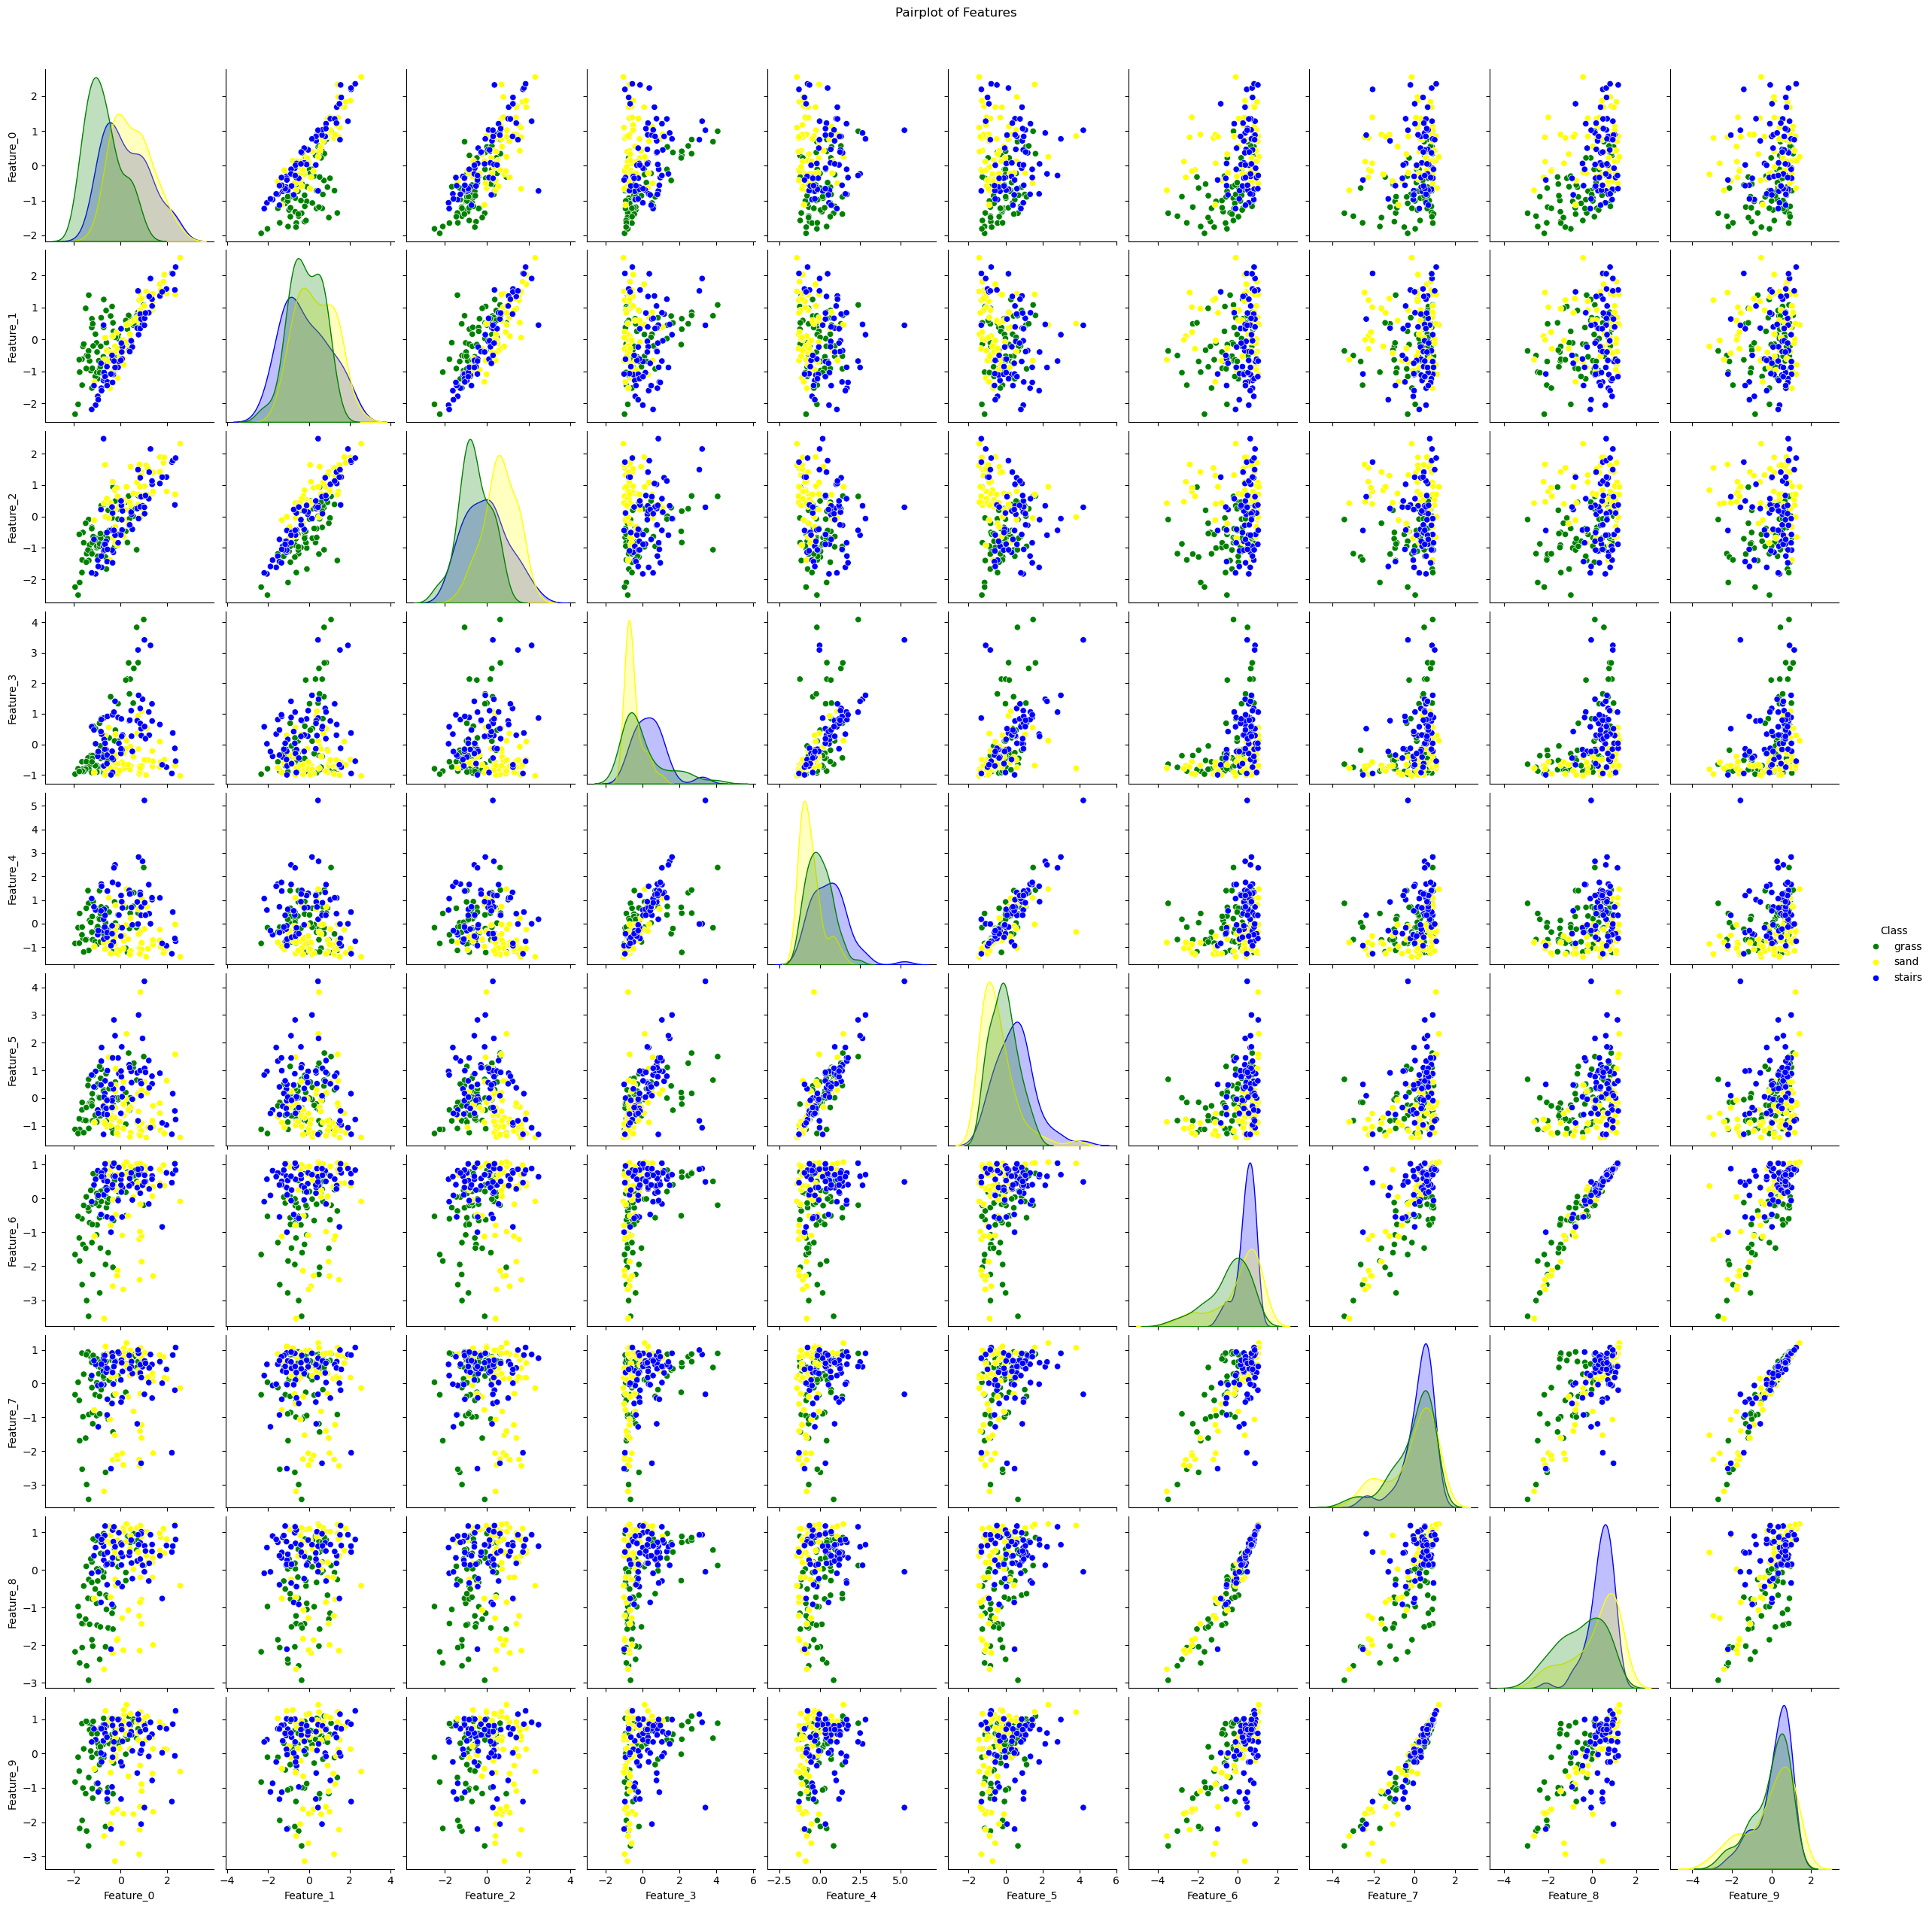

In [46]:
# Pairplot
sns.pairplot(df, hue='Class', diag_kind='kde', palette=['green', 'yellow', 'blue'])
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

The feature pairs (7, 9) and (6, 8) exhibit an approximately linear relationship.

### Histograms

    - Plot a histogram for each Z-scored feature. Plot all the image classes in the same figure and use different color for each.


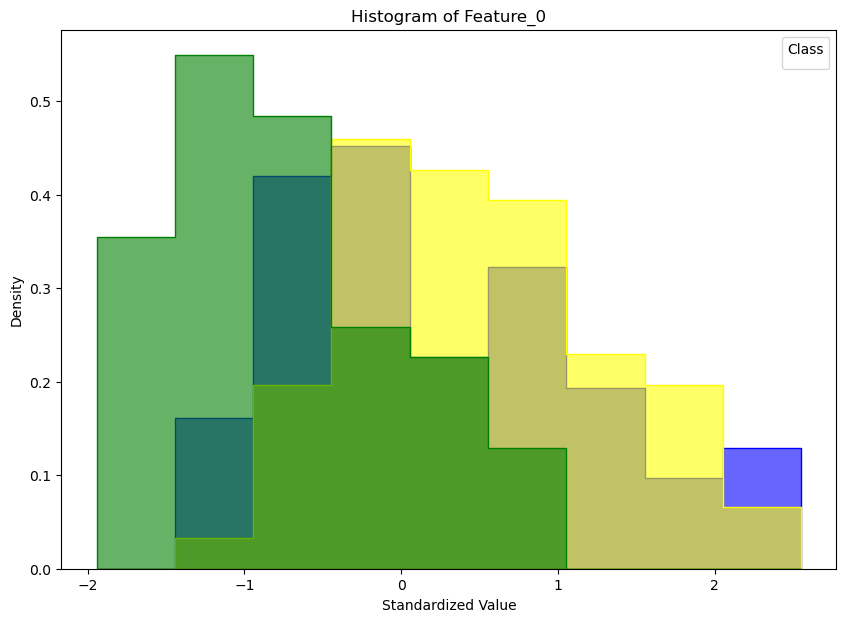

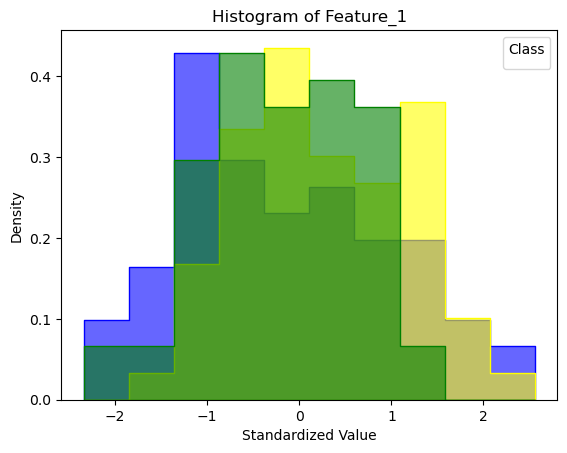

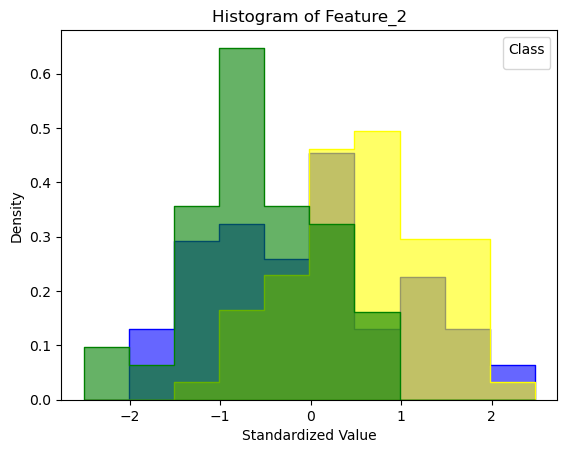

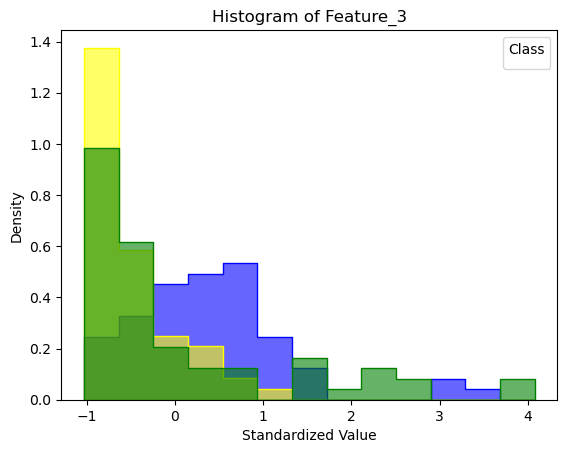

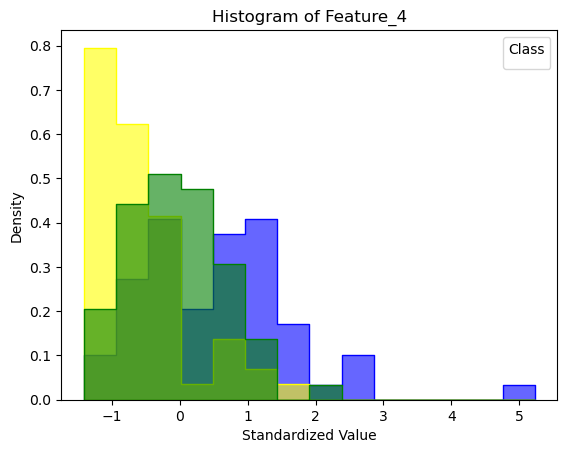

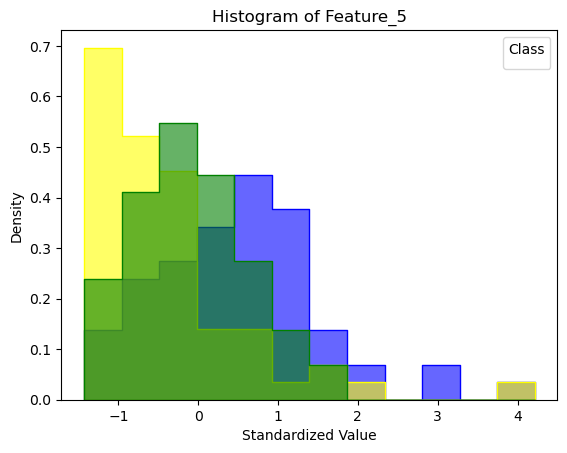

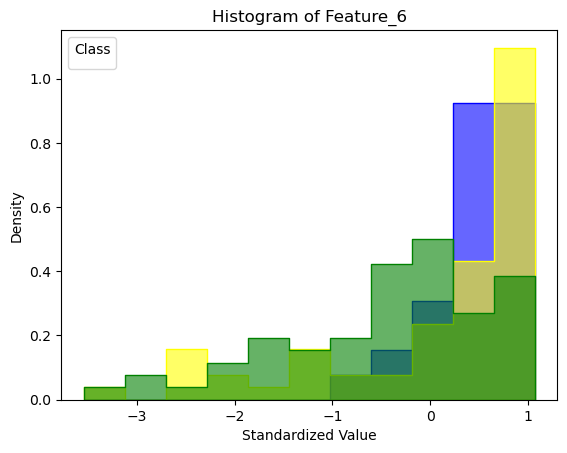

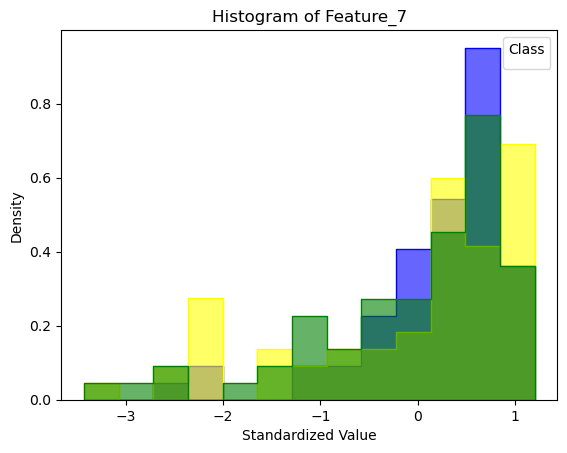

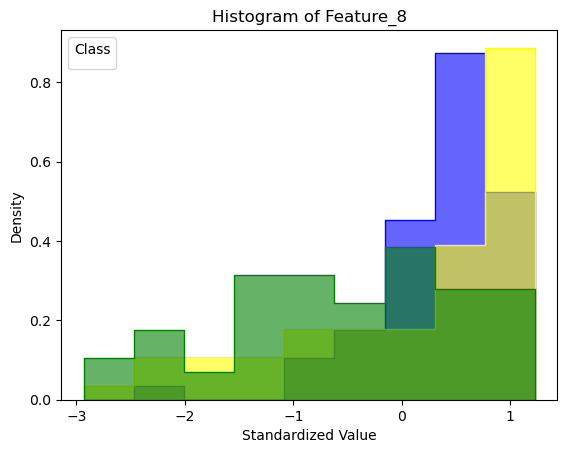

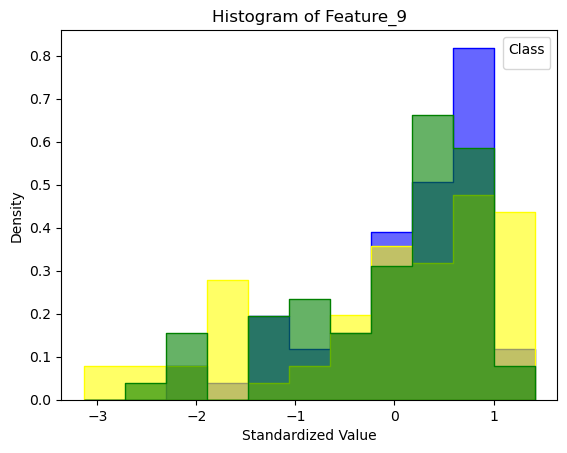

In [66]:
plt.figure(figsize=(10, 7))
for i, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, hue='Class', element='step', stat='density', common_norm=False, palette=['green', 'yellow', 'blue'], alpha=0.6)
    plt.title(f"Histogram of {col}")
    plt.xlabel("Standardized Value")
    plt.ylabel("Density")
    plt.legend(title="Class")
    plt.show()

The features that show discriminative power over image classes based on the histograms are Feature 3, Feature 4, Feature 5, Feature 6, Feature 7, Feature 8, and Feature 9. These features display distinct distributions for different classes, with minimal overlap, making them useful for classification.

In contrast, Feature 0, Feature 1, and Feature 2 have significant overlap between classes, meaning they are less effective in distinguishing image categories.

### PCA

- PCA
    - Plot the image glasses using different colors.

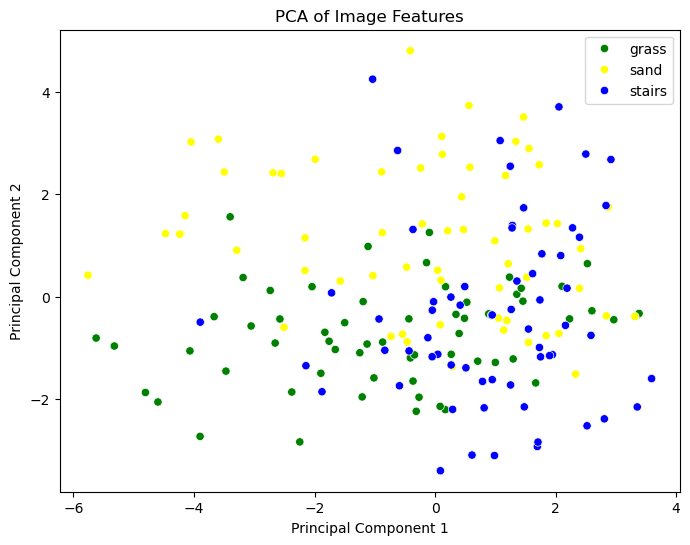

In [67]:
# PCA Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizing PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette=['green', 'yellow', 'blue'])
plt.title("PCA of Image Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

The PCA scatter plot does not show well-separated clusters. The points representing grass (green), sand (yellow), and stairs (blue) are spread out, with significant overlap between the classes. \
This figure suggests that classification with this data might be challenging because there are high overlap between the classes and there is no string linear separability.

## Build classifiers and select the best hyperparameters with cross validation

Perform model selection for each classifier. Use 5-fold stratified cross validation (*StratifiedKFold* and *GridSearchCV* from sklearn). Use the following hyperparameters:

- Ridge Classifier
    - strength of the regularization term: alpha = [0.001, 0.01, 0.1, 1.0]

- Random Forest
    - n_estimators from 100 to 300 with 50 steps
    - max_features = ['sqrt', 'log2', None]
    - whether to use bootstrap or not 
    
- MLP
    - use one hidden layer
    - number of neurons in the hidden layer from 15 to 40 in 5 neuron steps
    - activation function: hyperbolic tanh function and rectified linear unit function
    - solver: stochastic gradient descent and adam
    - validation_fraction: 0.1 and 0.3
    - strength of the L2 regularization term: alpha = [0.01, 0.1, 1]

For each classifier:
- Report the selected combination of hyperparameters <br>
- Report the accuracy value for each hyperparameter combination <br>

For Random Forest model, report the feature importance for each feature. Which features seem to be the most important? Does this correspond with the observations you made in the data exploration?

In [68]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import parallel_backend
import warnings
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Classifier Models
models = {
    'Ridge': RidgeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

# Hyperparameter Grid
param_grids = {
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1.0]},
    'RandomForest': {'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['sqrt', 'log2', None], 'bootstrap': [True, False]},
    'MLP': {'hidden_layer_sizes': [(x,) for x in range(15, 41, 5)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.1, 1]}
}

# Cross-validation & GridSearch
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
    with parallel_backend("multiprocessing"):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best params for {model_name}: {grid_search.best_params_}")
    print(f"Best accuracy: {grid_search.best_score_}\n")

# Print Feature Importance for Random Forest
rf_model = best_models['RandomForest']
feature_importances = rf_model.feature_importances_
feature_names = [f'Feature_{i}' for i in range(X_scaled.shape[1])]

print("Feature Importance for Random Forest:")
for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance:.4f}")

Training Ridge...
Best params for Ridge: {'alpha': 0.001}
Best accuracy: 0.7563218390804598

Training RandomForest...
Best params for RandomForest: {'bootstrap': False, 'max_features': 'log2', 'n_estimators': 150}
Best accuracy: 0.7218390804597702

Training MLP...
Best params for MLP: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (25,), 'solver': 'adam'}
Best accuracy: 0.8239080459770115

Feature Importance for Random Forest:
Feature_0: 0.1799
Feature_1: 0.1009
Feature_2: 0.1077
Feature_3: 0.1332
Feature_4: 0.0861
Feature_5: 0.0662
Feature_6: 0.1124
Feature_7: 0.0614
Feature_8: 0.0928
Feature_9: 0.0594


## Estimate the performance of the models with nested cross-validation

Estimate the performance of each model using nested cross validation. <br>
We'll use 4-fold Stratified Kfold cross-validation and the same parameter ranges as earlier for the inner loop. <br>
For the outer loop we'll use 5-fold Stratified Kfold cross-validation.

For each classifier: 
- Ridge Classifier
- Random Forest
- MLP

    Report the selected combination of the hyperparameters and the accuracy value for the best hyperparameter combination. <br> 
    Create a confusion matrix of the results. <br>
    Calculate the mean accuracy of the outer rounds. What does it mean?

In [72]:
# Cross validation strategies
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for model_name, model in models.items():
    best_combination = None
    best_combination_accuracy = -np.inf
    all_scores = []
    
    print(f'\n{model_name} - Selected Hyperparameter Combinations:')
    
    for train_idx, test_idx in outer_cv.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Hyperparameter tuning with inner cross-validation
        grid_search = GridSearchCV(model, param_grids[model_name], cv=inner_cv, scoring='accuracy', n_jobs=-1)
        with parallel_backend("multiprocessing"):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
                grid_search.fit(X_train, y_train)
        
        # Evaluate on the outer test set
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        all_scores.append(score)
        
        print(f'  {best_params} - Accuracy: {score:.4f}')
        
        if score > best_combination_accuracy:
            best_combination = best_params
            best_combination_accuracy = score
            
    mean_accuracy = np.mean(all_scores)
    std_accuracy = np.std(all_scores)

    print(f'\n{model_name} - Best Hyperparameters: {best_combination}')
    print(f'Best Accuracy for Selected Hyperparameters: {best_combination_accuracy:.4f}')
    print(f'Mean Accuracy Across Outer Folds: {mean_accuracy:.4f} ± {std_accuracy:.4f}')



Ridge - Selected Hyperparameter Combinations:
  {'alpha': 0.001} - Accuracy: 0.8649
  {'alpha': 0.001} - Accuracy: 0.7568
  {'alpha': 1.0} - Accuracy: 0.7297
  {'alpha': 1.0} - Accuracy: 0.8378
  {'alpha': 0.001} - Accuracy: 0.8378

Ridge - Best Hyperparameters: {'alpha': 0.001}
Best Accuracy for Selected Hyperparameters: 0.8649
Mean Accuracy Across Outer Folds: 0.8054 ± 0.0524

RandomForest - Selected Hyperparameter Combinations:
  {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100} - Accuracy: 0.8378
  {'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 100} - Accuracy: 0.6757
  {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100} - Accuracy: 0.7297
  {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200} - Accuracy: 0.7297
  {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 200} - Accuracy: 0.7297

RandomForest - Best Hyperparameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 100}
Best Accuracy for Selected Hyp

The mean accuracy of the outer rounds represent how well the models perform on unseen data. We can see the Random Forest having the least accuracy 0.7405 and the results varying across folds, which means it's not generalizing well. Ridge classifier has better accuracy 0.8054. MLP has the best mean accuracy 0.8108 and generalizes well.

## Discussion

    - ### Which model performs the best and why? 
    The results show that:
    MLP (0.8108 ± 0.0452) has the highest mean accuracy, indicating the best generalization.
    Ridge (0.8054 ± 0.0524) performs similarly but with slightly higher variability.
    RandomForest (0.7405 ± 0.0530) has the lowest accuracy, suggesting it may not generalize as well.
    Thus, MLP performs the best because it achieves the highest mean accuracy and has a relatively low standard deviation, meaning it generalizes well across different test sets. <br><br>
    - ### What are the limitations?
    While training MLP was not able to converge withing the max iterations. The performances sometimes depend on the dataset split, as seen in the standard deviations. The hyperparameters ranges chosen for training may not actually cover the true optimal settings. <br><br>
    - ### How could the results be improved?
    - Increasing training data could improve generalization.
    - Expanding the grid search for MLP hidden layers, activation functions, and learning rates could yield better configurations.
    - Instead of using 5 fold nested cross validation, 10 fold cros validation can be used for better estimate.
